In [1]:
import sys
sys.executable.split('/')[-3] == 'puma_venv'

True

# Dataset description
This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview.

The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

Creator and Donor: Tjen-Sien Lim

## Attribute Information:

1. Wife's age 
    * (numerical) 
2. Wife's education 
    * (categorical) - 1=low, 2, 3, 4=high 
3. Husband's education
    * (categorical) - 1=low, 2, 3, 4=high 
4. Number of children ever born
    * (numerical)
5. Wife's religion
    * (binary) - 0=Non-Islam, 1=Islam 
6. Wife's now working? 
    * (binary) - 0=Yes, 1=No 
7. Husband's occupation
    * (categorical) - 1, 2, 3, 4
8. Standard-of-living index
    * (categorical) - 1=low, 2, 3, 4=high 
9. Media exposure
    * (binary) - 0=Good, 1=Not good 
10. Contraceptive method used
    * (class attribute) - 1=No-use, 2=Long-term, 3=Short-term


In [2]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

# Load data

In [6]:
data_dir = '../data'
data_file = 'cmc.data'

data_path = os.path.join(data_dir, data_file)

In [33]:
data = pd.read_csv(data_path, header=None)

# setting column names
data.columns = [
    'wife_age', 'wife_edu', 'husband_edu', 'n_children', 'wife_religion', 
    'wife_working', 'husband_occup', 'sol_index', 'media_exposure', 
    'class'
]

print('__'*50)
print('Data info:\n')
print(data_copy.info())
print('__'*50)
data.head()

____________________________________________________________________________________________________
Data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   wife_age        1473 non-null   int64 
 1   wife_edu        1473 non-null   object
 2   husband_edu     1473 non-null   object
 3   n_children      1473 non-null   int64 
 4   wife_religion   1473 non-null   object
 5   wife_working    1473 non-null   object
 6   husband_occup   1473 non-null   object
 7   sol_index       1473 non-null   object
 8   media_exposure  1473 non-null   object
 9   class           1473 non-null   object
dtypes: int64(2), object(8)
memory usage: 115.2+ KB
None
____________________________________________________________________________________________________


,wife_age,wife_edu,husband_edu,n_children,wife_religion,wife_working,husband_occup,sol_index,media_exposure,class
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


# Data explorations

In [45]:
data_copy = data.copy()

# define dictionaries for labels and replace values in dataframe

low_to_high_map = {
    1: 'low', 
    2: 'lower_middle', 
    3: 'upper_middle', 
    4: 'high'
}
data_copy['wife_edu'].replace(low_to_high_map, inplace=True)
data_copy['husband_edu'].replace(low_to_high_map, inplace=True)
data_copy['husband_occup'].replace(low_to_high_map, inplace=True)
data_copy['sol_index'].replace(low_to_high_map, inplace=True)

wife_religion_map = {
    0: 'non_Islam', 
    1: 'islam'
}
data_copy['wife_religion'].replace(wife_religion_map, inplace=True)

wife_working_map = {
    0: 'yes', 
    1: 'no'
}
data_copy['wife_working'].replace(wife_working_map, inplace=True)

media_exposure_map = {
    0: 'good', 
    1: 'not_good'
}
data_copy['media_exposure'].replace(media_exposure_map, inplace=True)

class_map = {
    1: 'no_use', 
    2: 'long_term', 
    3: 'short_term'
}
data_copy['class'].replace(class_map, inplace=True)

In [46]:
data_copy.describe()

,wife_age,n_children
count,1473.000000,1473.000000
mean,32.538357,3.261371
std,8.227245,2.358549
min,16.000000,0.000000
25%,26.000000,1.000000
50%,32.000000,3.000000
75%,39.000000,4.000000
max,49.000000,16.000000


In [47]:
data_copy.describe(include=['O'])

,wife_edu,husband_edu,wife_religion,wife_working,husband_occup,sol_index,media_exposure,class
count,1473,1473,1473,1473,1473,1473,1473,1473
unique,4,4,2,2,4,4,2,3
top,high,high,islam,no,upper_middle,high,good,no_use
freq,577,899,1253,1104,585,684,1364,629


# Visualizations

## Histograms

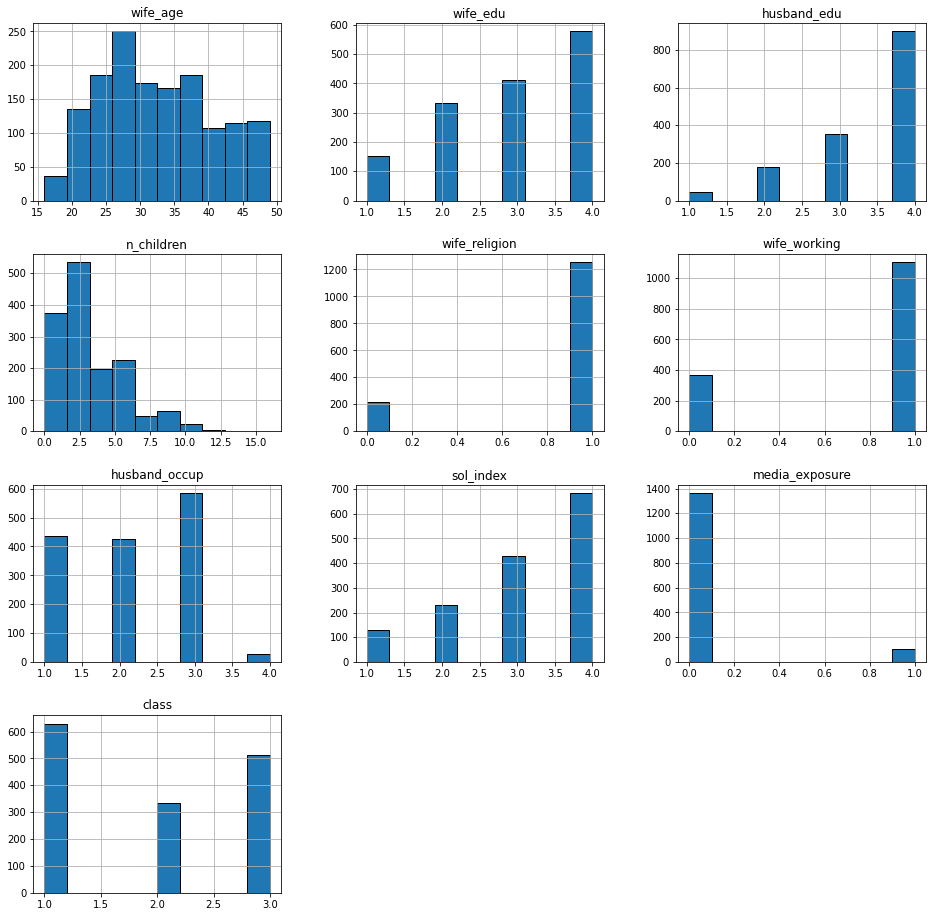

In [63]:
# how features are distributed in data
data.hist(
    edgecolor='black',
    # grid=False
)

fig = plt.gcf()
fig.set_size_inches(16, 16)

## Numerical features interaction

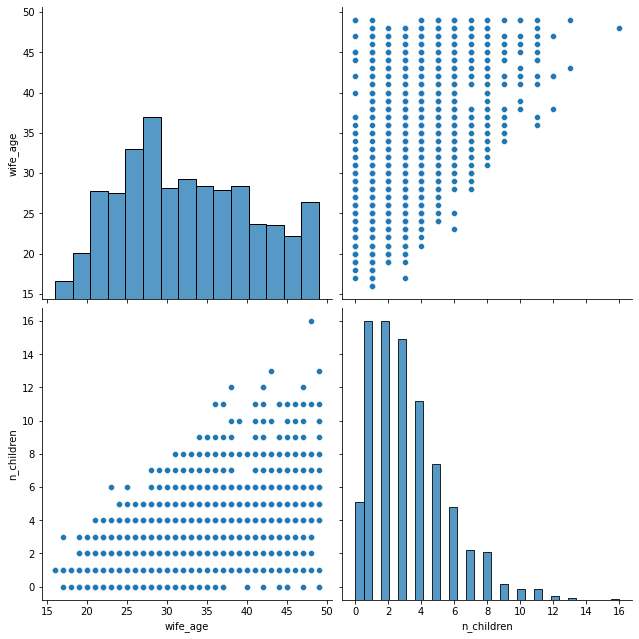

In [67]:
# interaction between pairs of features
sns.pairplot(
    data_copy,
    size=4.5
)
# sns.pairplot(data)
pass

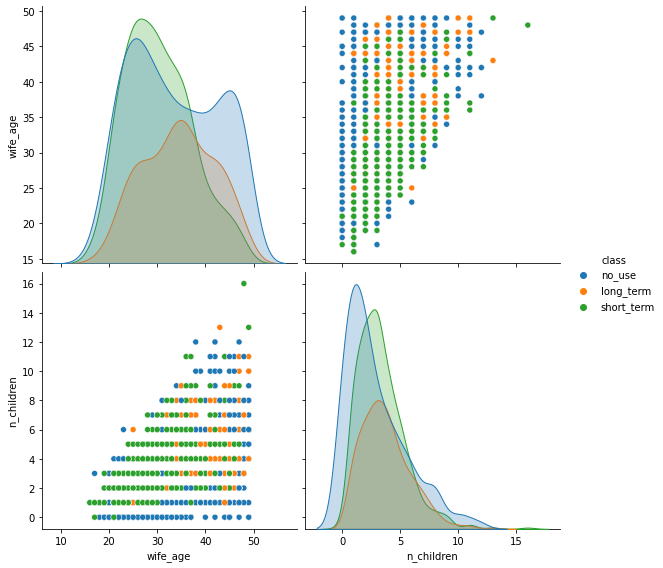

In [52]:
# interaction between pairs of features with contraceptive method used hue
sns.pairplot(
    data_copy,
    hue = "class",
    diag_kind="kde",
    size=4
)
pass

## Single feature visualizations

In [173]:
def draw_countplot(df, attr, hue=None, count_on_y=False, figsize=(10,5)):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=figsize)

    if count_on_y:
        sns.countplot(
            data=df,
            x=attr,
            hue=hue
        )
    else:
        sns.countplot(
            data=df,
            y=attr,
            hue=hue
        )


def draw_histplot(df, attr, n_bins=5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(10,5))

    sns.histplot(
        data=df,
        y=attr,
        bins=n_bins,
        shrink=0.8
    )

### Feature: wife_age

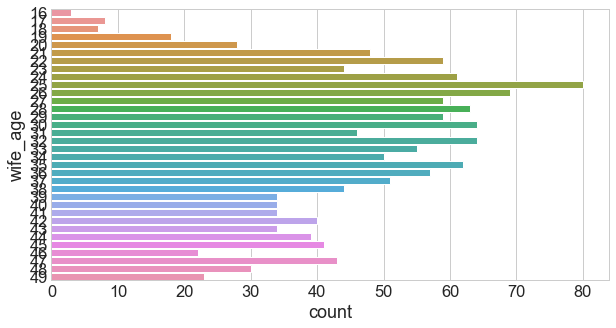

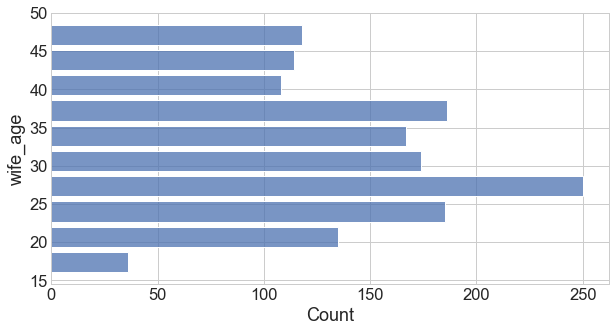

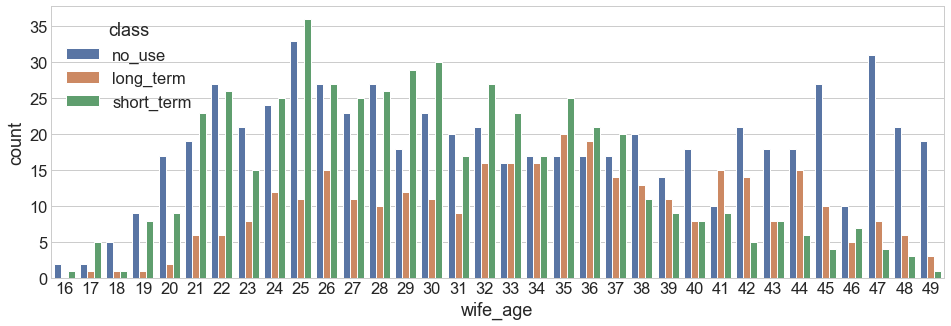

In [174]:
draw_countplot(data_copy, 'wife_age')
draw_histplot(data_copy, 'wife_age', n_bins=10)
draw_countplot(data_copy, 'wife_age', hue='class', count_on_y=True, figsize=(16,5))

<AxesSubplot:xlabel='class', ylabel='wife_age'>

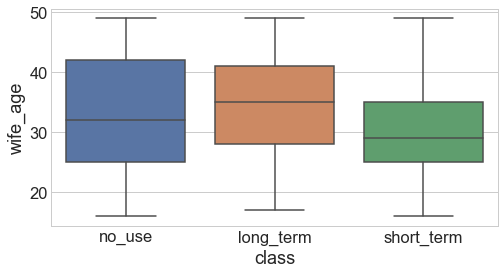

In [167]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,4))

sns.boxplot(data=data_copy, x='class', y='wife_age')

### Feature: wife_edu

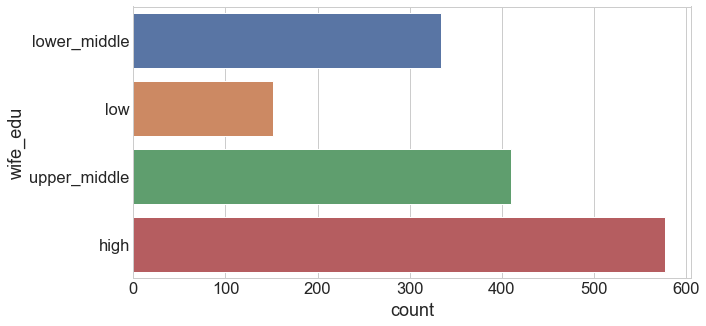

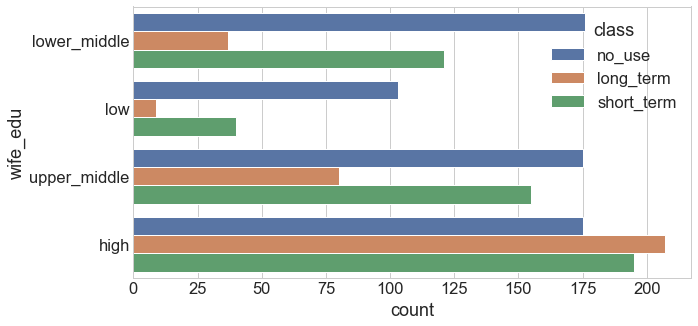

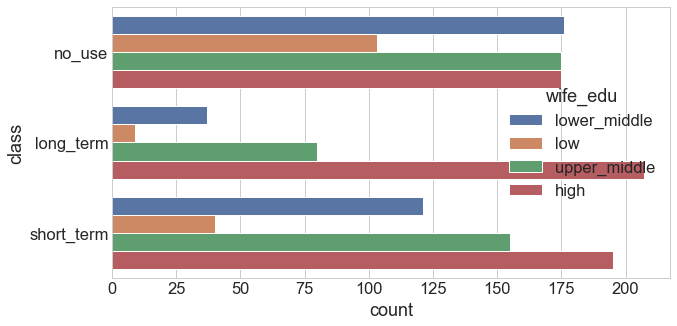

In [143]:
draw_countplot(data_copy, 'wife_edu')
draw_countplot(data_copy, 'wife_edu', hue='class')
draw_countplot(data_copy, 'class', hue='wife_edu')

### Feature: husband_edu

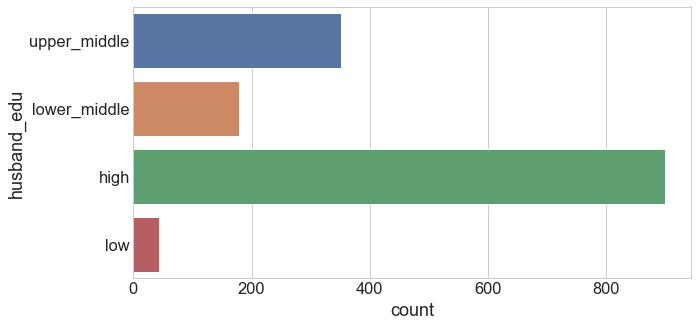

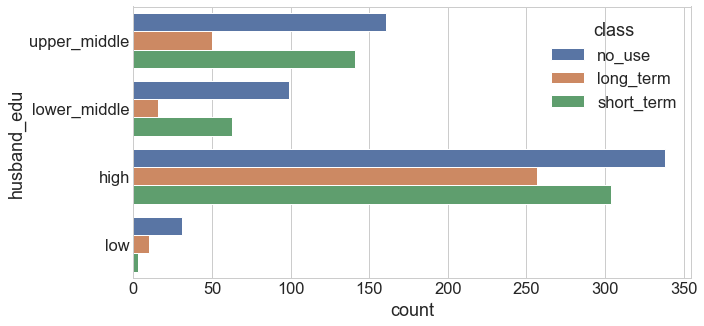

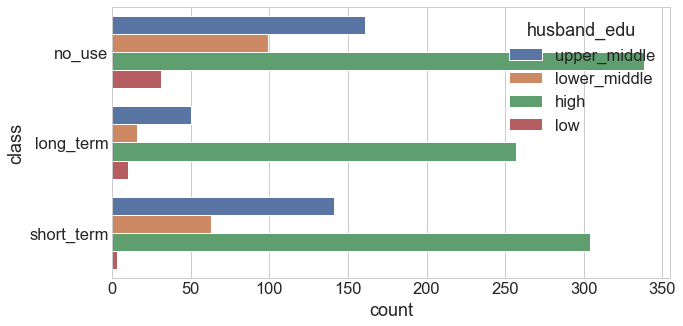

In [144]:
draw_countplot(data_copy, 'husband_edu')
draw_countplot(data_copy, 'husband_edu', hue='class')
draw_countplot(data_copy, 'class', hue='husband_edu')

### Feature: n_children

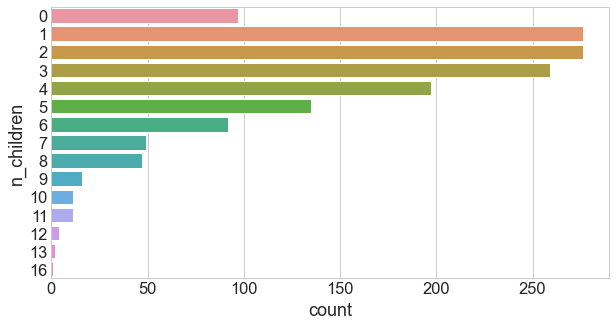

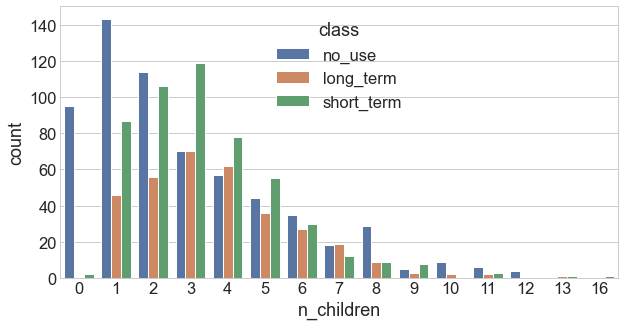

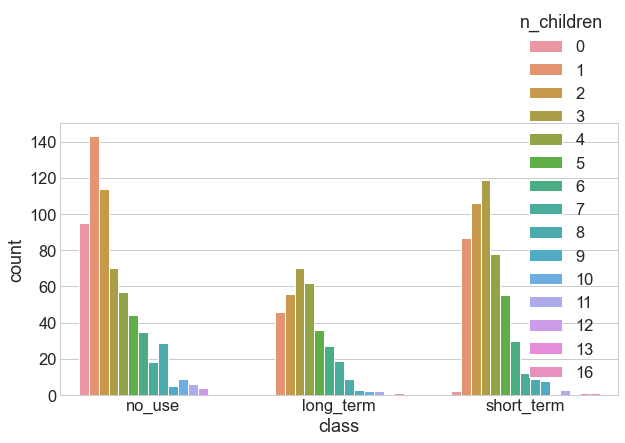

In [155]:
draw_countplot(data_copy, 'n_children')
draw_countplot(data_copy, 'n_children', hue='class', count_on_y=True)
draw_countplot(data_copy, 'class', hue='n_children', count_on_y=True)

### Feature: wife_religion

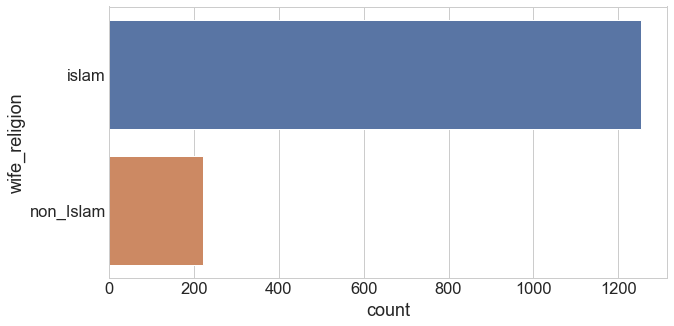

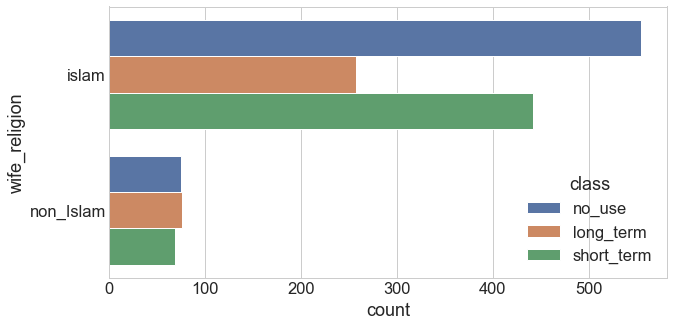

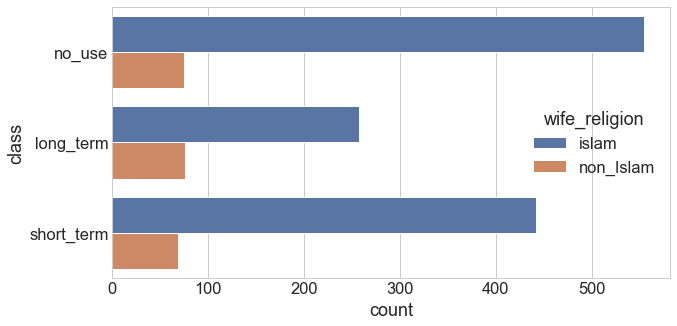

In [146]:
draw_countplot(data_copy, 'wife_religion')
draw_countplot(data_copy, 'wife_religion', hue='class')
draw_countplot(data_copy, 'class', hue='wife_religion')

### Feature: wife_working

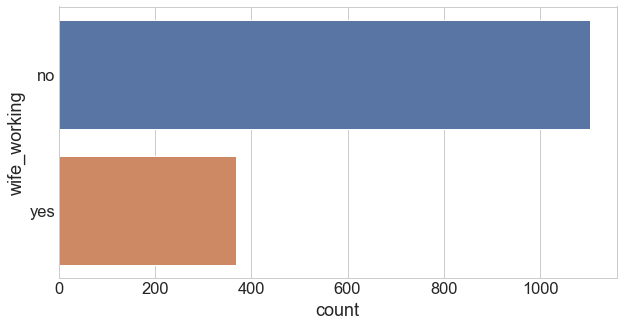

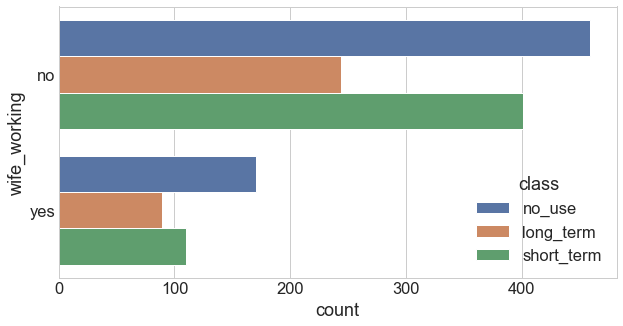

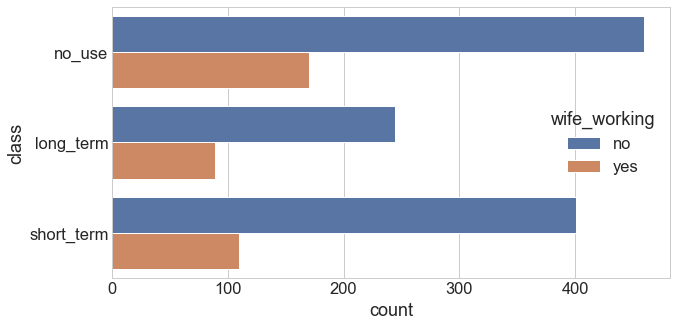

In [147]:
draw_countplot(data_copy, 'wife_working')
draw_countplot(data_copy, 'wife_working', hue='class')
draw_countplot(data_copy, 'class', hue='wife_working')

### Feature: husband_occup

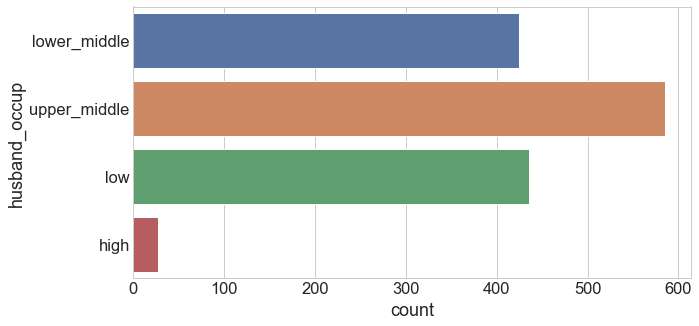

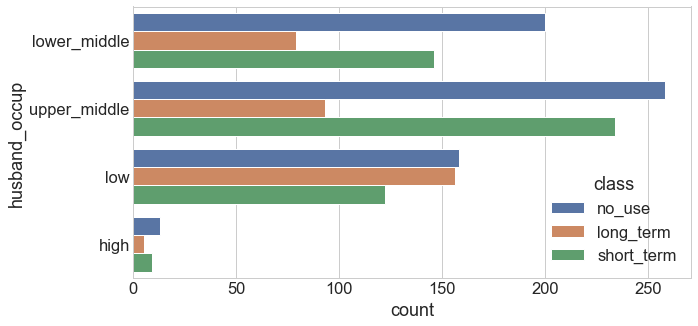

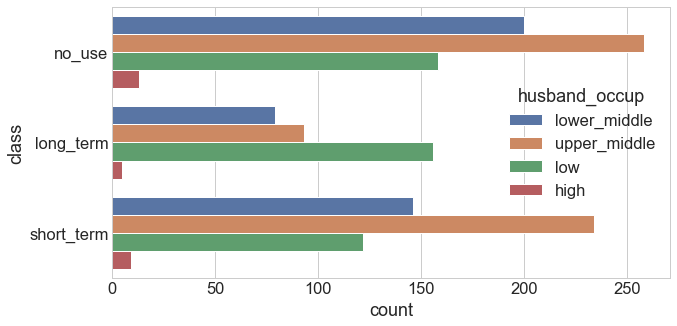

In [148]:
draw_countplot(data_copy, 'husband_occup')
draw_countplot(data_copy, 'husband_occup', hue='class')
draw_countplot(data_copy, 'class', hue='husband_occup')

### Feature: sol_index

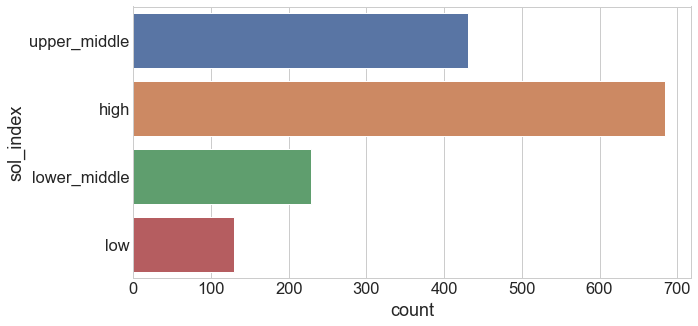

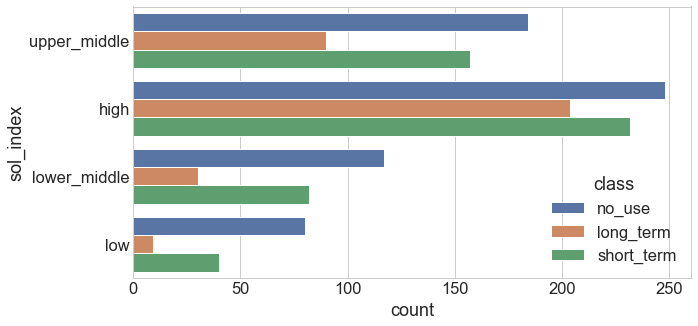

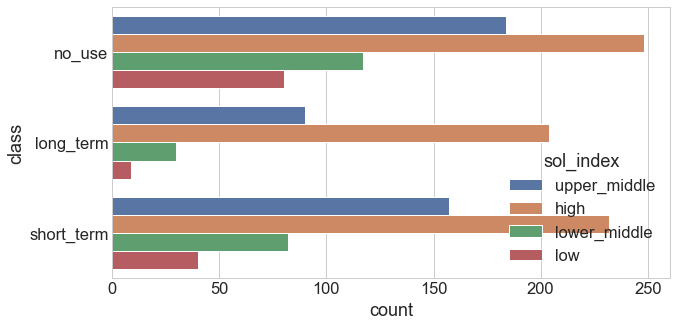

In [149]:
draw_countplot(data_copy, 'sol_index')
draw_countplot(data_copy, 'sol_index', hue='class')
draw_countplot(data_copy, 'class', hue='sol_index')

### Feature: media_exposure

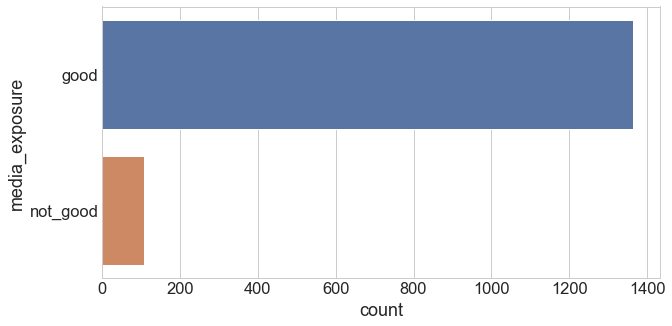

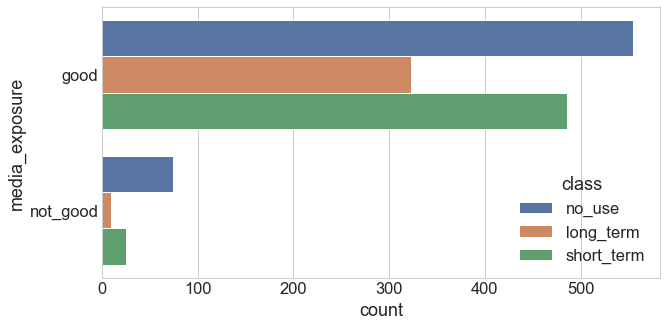

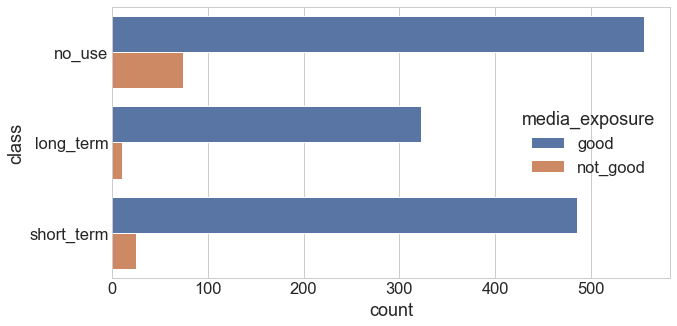

In [150]:
draw_countplot(data_copy, 'media_exposure')
draw_countplot(data_copy, 'media_exposure', hue='class')
draw_countplot(data_copy, 'class', hue='media_exposure')

### Feature: class (contraceptive method used)

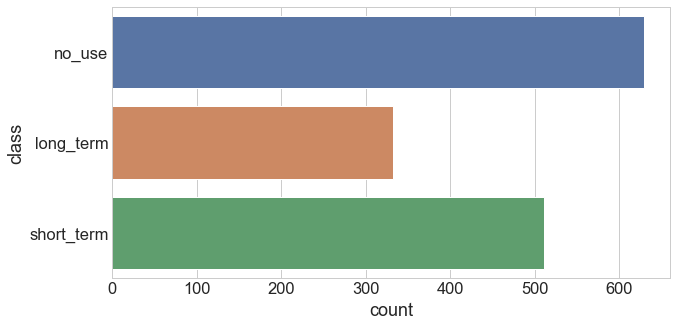

In [130]:
draw_countplot(data_copy, 'class')

## Other visualizations

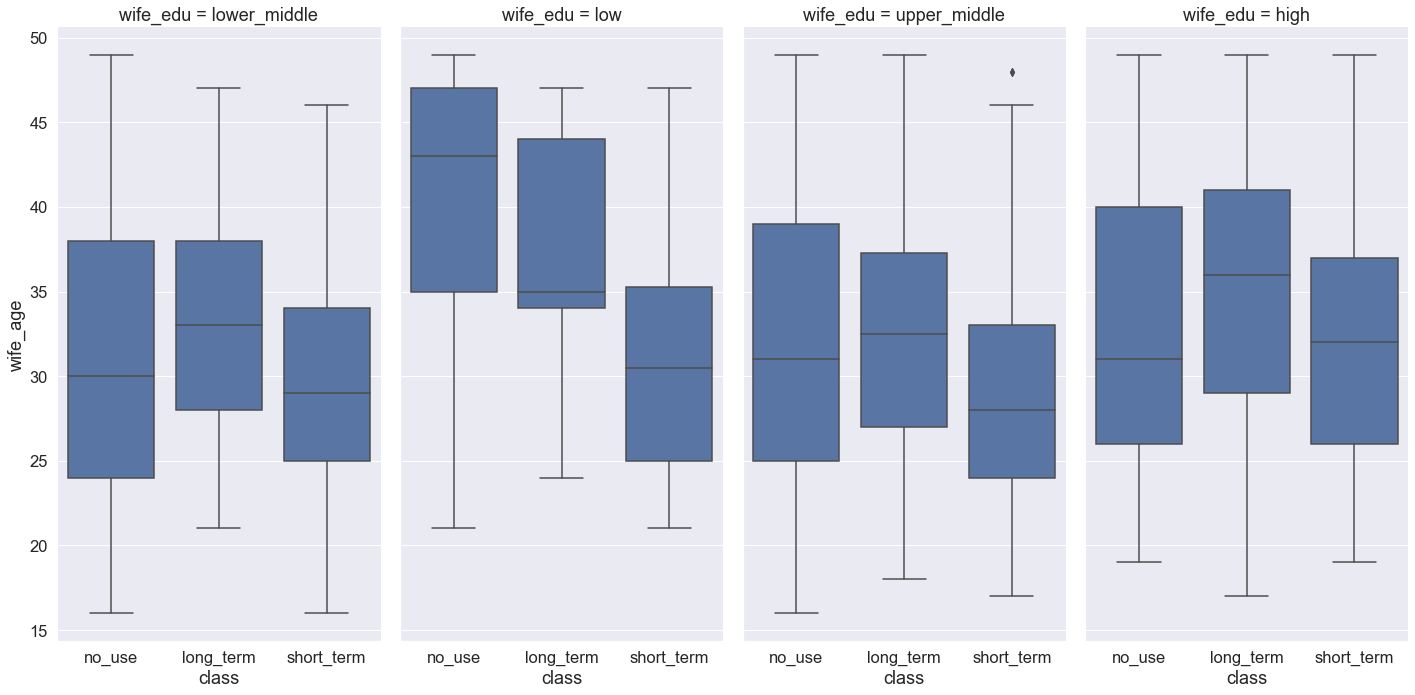

In [142]:
# effect of wife_edu and wife_age on class (contraceptive method used), across wife_edu
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.5)

g = sns.FacetGrid(
    data_copy, 
    col='wife_edu',
    size=10, 
    aspect=0.5
)

g = g.map(sns.boxplot, 'class', 'wife_age')